## Including Headers

In [1]:
import modelo as m
import pandas as pd
import Bio.KEGG.REST as rkg
import Bio.KEGG.Enzyme as ex
import networkx as nx
import cufflinks as cf
import pylab as pl
import numpy as np
import plotly.tools as tls
import powerlaw
from plotly.graph_objs import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from plotly.offline import *
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import random

random.seed(42)

init_notebook_mode(connected=True)

In [2]:
def roc(cv, X, y, mean_fpr, aucs,tprs,classifier,cls):
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example'+cls)
    plt.legend(loc="lower right")
    return (plt)

## Reading network data and processing 

In [3]:
eco = nx.read_graphml("eco.graphml")
eco = eco.to_undirected()
eco_nodes = list(eco.nodes())
eco_nodes.remove('undefined')
orf_queries = dict()
product_queries = []
for i in range(len(eco_nodes)):
    gene = rkg.kegg_get(eco_nodes[i])
    tmp = ex.read(gene)
    if eco_nodes[i].startswith("eco:"):
        orf_queries[eco_nodes[i]]=tmp.name[0]

## Reading essenciality data and processing 

In [4]:
nodes_eco = {v: k for k, v in orf_queries.items()}
table = pd.read_table("EcoliNetData.dat")
node2rem = []
for j in eco.nodes():
    if orf_queries.get(j,None) == None:
        node2rem.append(j)
eco.remove_nodes_from(node2rem)

## Getting graph features

In [5]:
close_cent = nx.closeness_centrality(eco)
bet_cent = nx.betweenness_centrality(eco)
eigen_cent = nx.eigenvector_centrality(eco)
load_cent = nx.load_centrality(eco)
harm_cent = {k:(v/(len(eco)-1)) for k,v in nx.harmonic_centrality(eco).items()}
damage = m.damage_lemke(eco)
ei = nx.estrada_index(eco)
cco = nx.clustering(eco)
sub_cent = {k:(v/ei) for k,v in nx.subgraph_centrality(eco).items()}
deg_cent = nx.degree_centrality(eco)
pagerank = nx.pagerank(eco)
hits = nx.hits(eco)
lreach_cent = {k:nx.local_reaching_centrality(eco, k) for k in eco.nodes()}
ind_set = {k:len(nx.maximal_independent_set(eco,[k])) for k in eco.nodes()}



eco:b2076 0
eco:b1232 671
eco:b2746 671
eco:b2926 671
eco:b0477 671
eco:b0995 0
eco:b0526 671
eco:b2515 671
eco:b2263 671
eco:b2367 0
eco:b1991 5
eco:b3744 671
eco:b3846 671
eco:b1512 0
eco:b1921 0
eco:b4139 671
eco:b4025 671
eco:b1882 0
eco:b2143 671
eco:b0617 0
eco:b1914 0
eco:b3236 671
eco:b2705 671
eco:b1881 0
eco:b2498 671
eco:b3957 671
eco:b2260 671
eco:b4053 671
eco:b1113 0
eco:b1046 671
eco:b2132 671
eco:b2500 671
eco:b2315 671
eco:b3571 671
eco:b0570 0
eco:b0417 671
eco:b4258 671
eco:b1129 0
eco:b0619 0
eco:b1710 671
eco:b4471 671
eco:b0154 671
eco:b1780 671
eco:b2554 0
eco:b3397 671
eco:b1119 671
eco:b0963 671
eco:b3930 671
eco:b0826 0
eco:b0595 671
eco:b3729 671
eco:b3829 671
eco:b3917 0
eco:b2508 671
eco:b3633 671
eco:b4355 0
eco:b4177 671
eco:b2599 671
eco:b3831 671
eco:b0969 0
eco:b0116 671
eco:b3359 671
eco:b3041 671
eco:b0517 4
eco:b2935 671
eco:b0142 671
eco:b1444 671
eco:b1200 671
eco:b3176 671
eco:b3253 671
eco:b4117 671
eco:b2954 671
eco:b1515 0
eco:b2499 671
eco:b1

eco:b3605 671
eco:b1916 0
eco:b3500 671
eco:b3845 671
eco:b0238 671
eco:b3360 671
eco:b3993 671
eco:b2020 671
eco:b3911 0
eco:b4431 0
eco:b0414 671
eco:b4154 671
eco:b3008 671
eco:b0475 671
eco:b2542 671
eco:b2062 0
eco:b0026 671
eco:b3693 671
eco:b3164 671
eco:b0463 0
eco:b3902 671
eco:b0516 4
eco:b3708 671
eco:b1385 671
eco:b2067 0
eco:b4384 671
eco:b3025 0
eco:b2799 671
eco:b0724 671
eco:b1539 671
eco:b2838 671
eco:b2153 671
eco:b0529 671
eco:b3648 671
eco:b1992 5
eco:b2557 671
eco:b4090 671
eco:b2476 671
eco:b3867 671
eco:b3850 671
eco:b2049 671
eco:b4039 671
eco:b2052 671
eco:b3551 671
eco:b3992 671
eco:b4192 671
eco:b3973 671
eco:b2217 0
eco:b1865 671
eco:b3722 0
eco:b0356 4
eco:b0612 0
eco:b2765 671
eco:b3197 671
eco:b0767 671
eco:b3368 671
eco:b2842 671
eco:b1854 671
eco:b2472 671
eco:b0383 671
eco:b0161 0
eco:b1106 671
eco:b1886 0
eco:b4323 671
eco:b0403 671
eco:b0759 671
eco:b2256 671
eco:b2114 671
eco:b1054 671
eco:b0347 671
eco:b2223 0
eco:b2042 671
eco:b3141 671
eco:b1518 

In [6]:
aux = []
for i,j in zip(table["Feature/Product"], table["Class(1:essential 2:noessential)"]):
    tmp = nodes_eco.get(i,None)
    if tmp != None:
        aux.append([tmp, eigen_cent[tmp], close_cent[tmp], bet_cent[tmp], load_cent[tmp], harm_cent[tmp], lreach_cent[tmp], 
                     sub_cent[tmp], deg_cent[tmp], cco[tmp], pagerank[tmp], hits[0][tmp],ind_set[tmp],damage[tmp], j])


In [7]:
data = pd.DataFrame(aux, columns = ["ec","eigenvector_centrality","closeness_centrality","betweenness_centrality",
                                    "load_centrality","harmonic_centrality","local_reach_centrality","subgraph_centrality",
                                    "degree_centrality","clustering_coefficient","pagerank","hits","ind_set_maximal","damage","class"])
data.iloc[:,1:data.shape[1]]
#Normalize values 
data['ind_set_maximal'] = data['ind_set_maximal']/max(data['ind_set_maximal'])
data['damage'] = data['damage']/max(data['damage'])

# Machine Learning

## Pre processing features

### Getting principal component from 0.95 percent of confidence

(911, 2)


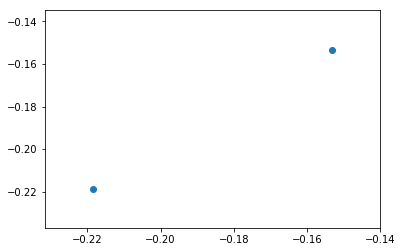

In [8]:
pca = PCA(0.95)
princComp = pca.fit_transform(data.iloc[:,1:data.shape[1]-1])
print(princComp.shape)
plt.scatter(princComp[0],princComp[0])

## Chi square values obtained by all feature correlation

In [9]:
chi2_manual = sklearn.feature_selection.chi2(data.iloc[:,1:data.shape[1]-1],data.iloc[:,-1:])
for i in range(len(chi2_manual[1])):
    print(data.columns[i+1])
    print(chi2_manual[1][i])

X_new = SelectKBest(chi2, k=5).fit(data.iloc[:,1:data.shape[1]-1],data.iloc[:,-1:])
print(X_new.get_support())

eigenvector_centrality
0.6296363002085967
closeness_centrality
0.44016637583430007
betweenness_centrality
0.7324694486038279
load_centrality
0.7404290912832198
harmonic_centrality
0.43780078078976403
local_reach_centrality
0.43780078078976414
subgraph_centrality
0.8060181632691514
degree_centrality
0.9724011099891665
clustering_coefficient
0.15157375492104572
pagerank
0.9599778077518402
hits
0.856220835283239
ind_set_maximal
0.9967107755134016
damage
0.002781793614196544
[False  True False False  True  True False False  True False False False
  True]


## Selecting features from model


In [10]:

X_svm, y_svm = data.iloc[:,:-1], data.iloc[:,-1]
X_svm = X_svm.drop('ec', axis=1)
lsvc = LinearSVC(penalty="l1", dual=False).fit(X_svm, y_svm)
model = SelectFromModel(lsvc, prefit=True)
X_svm = model.transform(X_svm)
X_svm.shape




(911, 4)

## Processing data

In [11]:
random_state = np.random.RandomState(0) 
cv = StratifiedKFold(n_splits=10)

In [12]:
X,y = data.iloc[:,1:-1],data.iloc[:,-1]
for i in range(y.shape[0]):
    if y[i] == 1:
        y.at[i] = 0
    elif y[i] == 0 or y[i]==2:
        y.at[i] = 1
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)


In [13]:
random_state = np.random.RandomState(0) 
cv = StratifiedKFold(n_splits=10)


In [14]:
list(X.iloc[:,X_new.get_support()])

['closeness_centrality',
 'harmonic_centrality',
 'local_reach_centrality',
 'clustering_coefficient',
 'damage']

#### <span style="color:green">Rodar todos os classificadores, selecionar por p-valor, ou k best</span>.

In [15]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(kernel="rbf", C=0.025, probability=True),
    SVC(gamma=2, C=1,probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()]
cls = ['KNN',
      "SVM linear",
      "SVM RBF",
      "SVM gamma",
      "Gauss",
      "AD",
      "RF",
      "MLP",
      "AdaBoost",
      "Net Bayes"
      ]

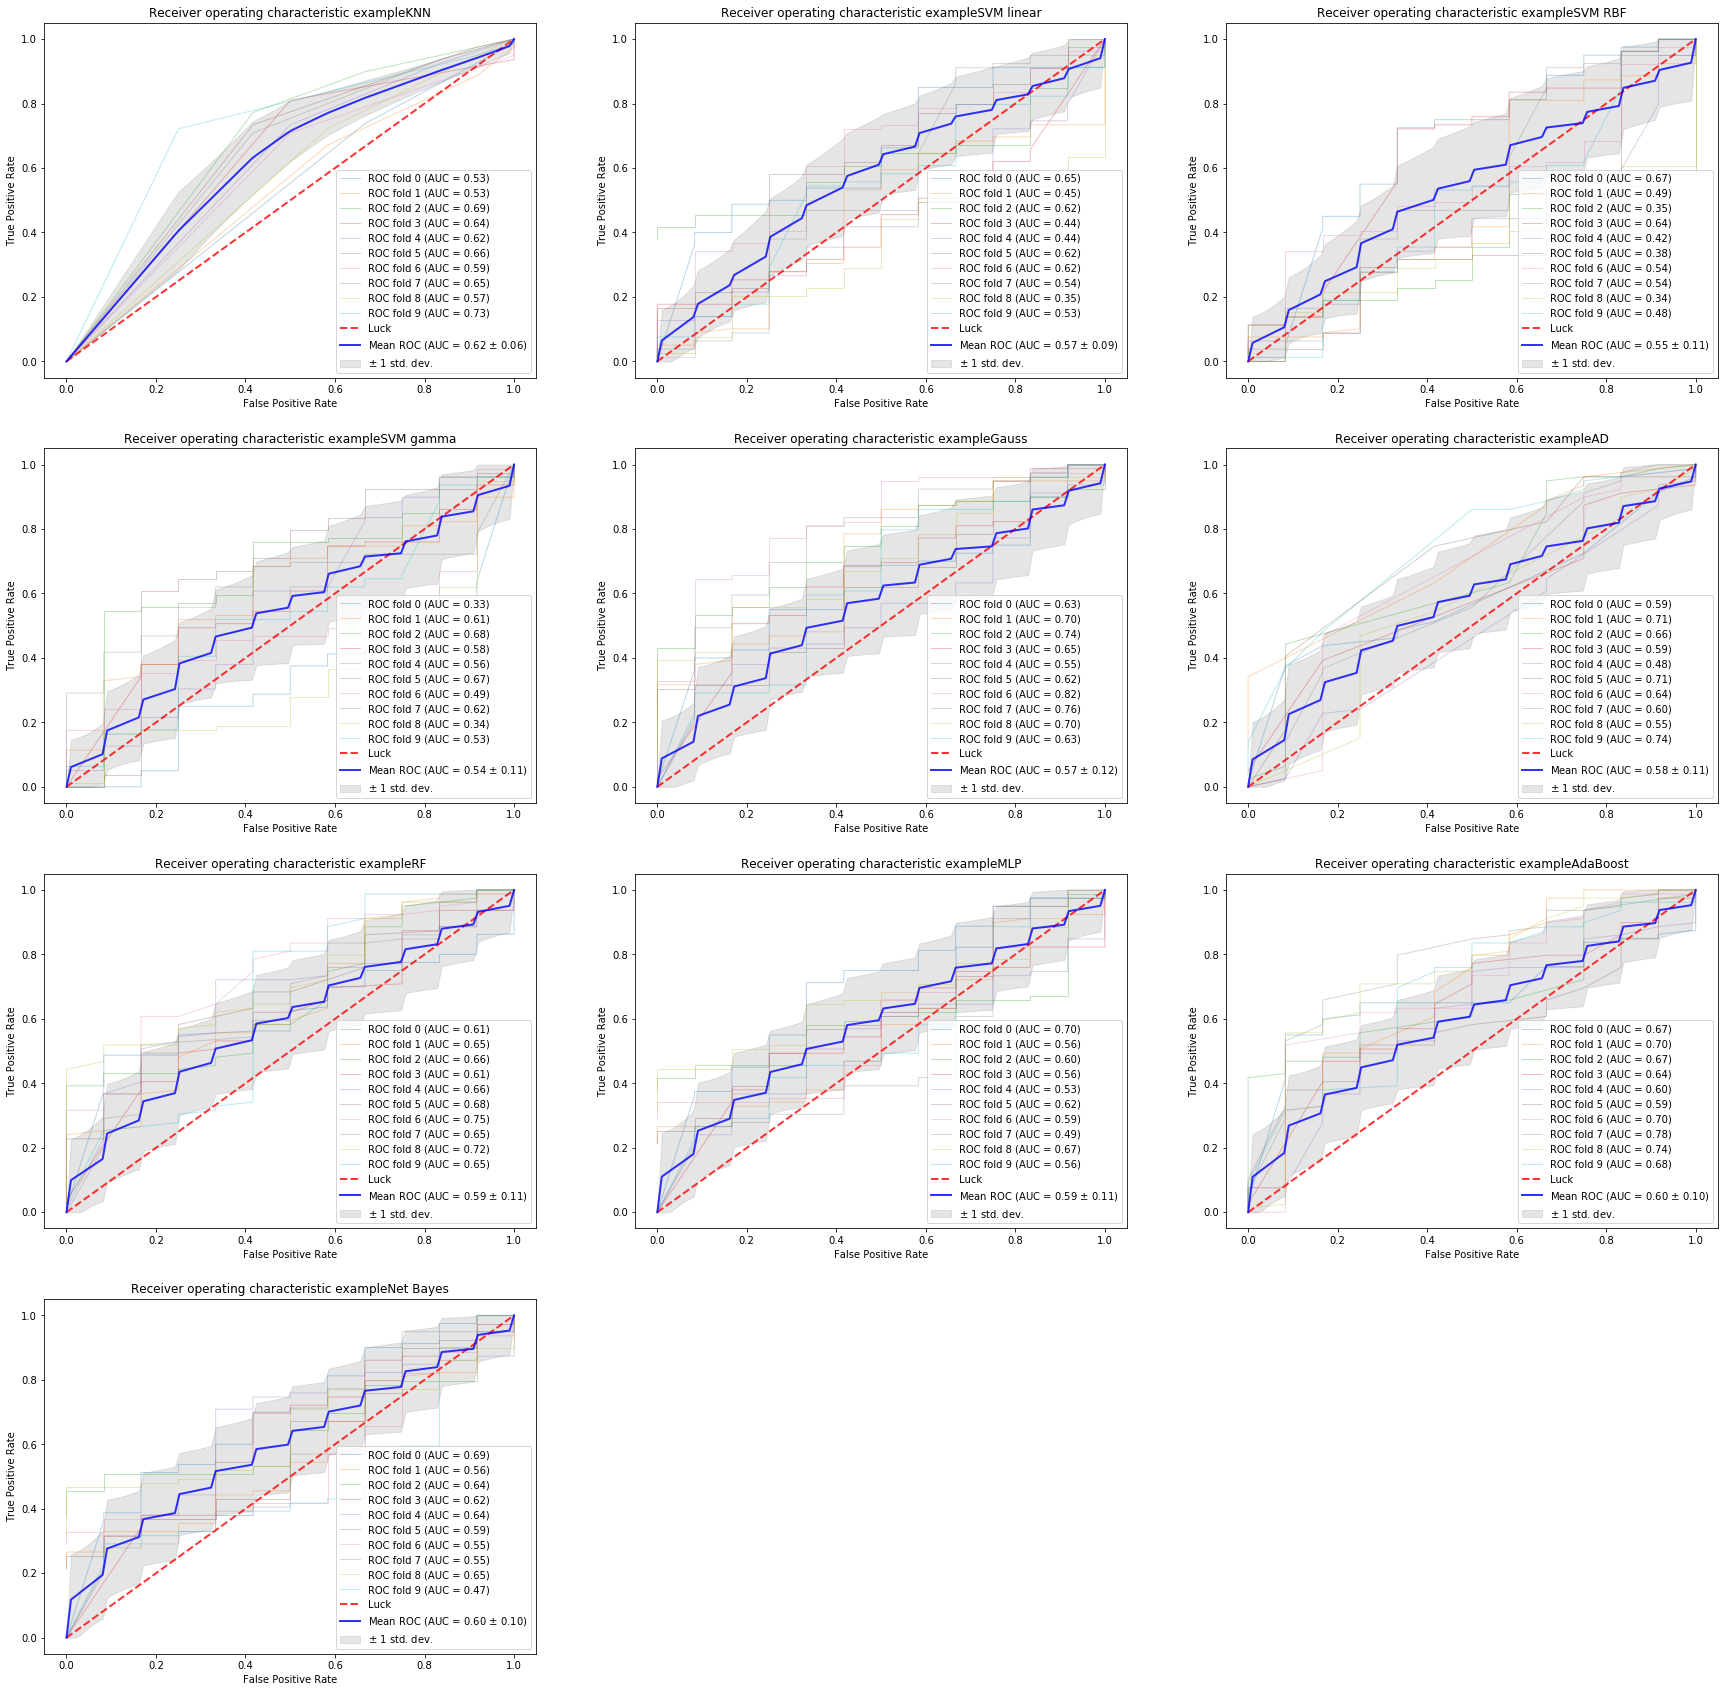

In [16]:
fig = plt.figure(figsize=(30,30))
i = 1
row = 4
col = 3
for c,clf in zip(cls,classifiers):
    a = fig.add_subplot(row, col, i)
    imgshow = roc(cv, X.iloc[:,X_new.get_support()], y, mean_fpr_dall, aucs_dall,tprs_dall,clf,c)
    i+=1
fig.savefig("all_classifiers.png")

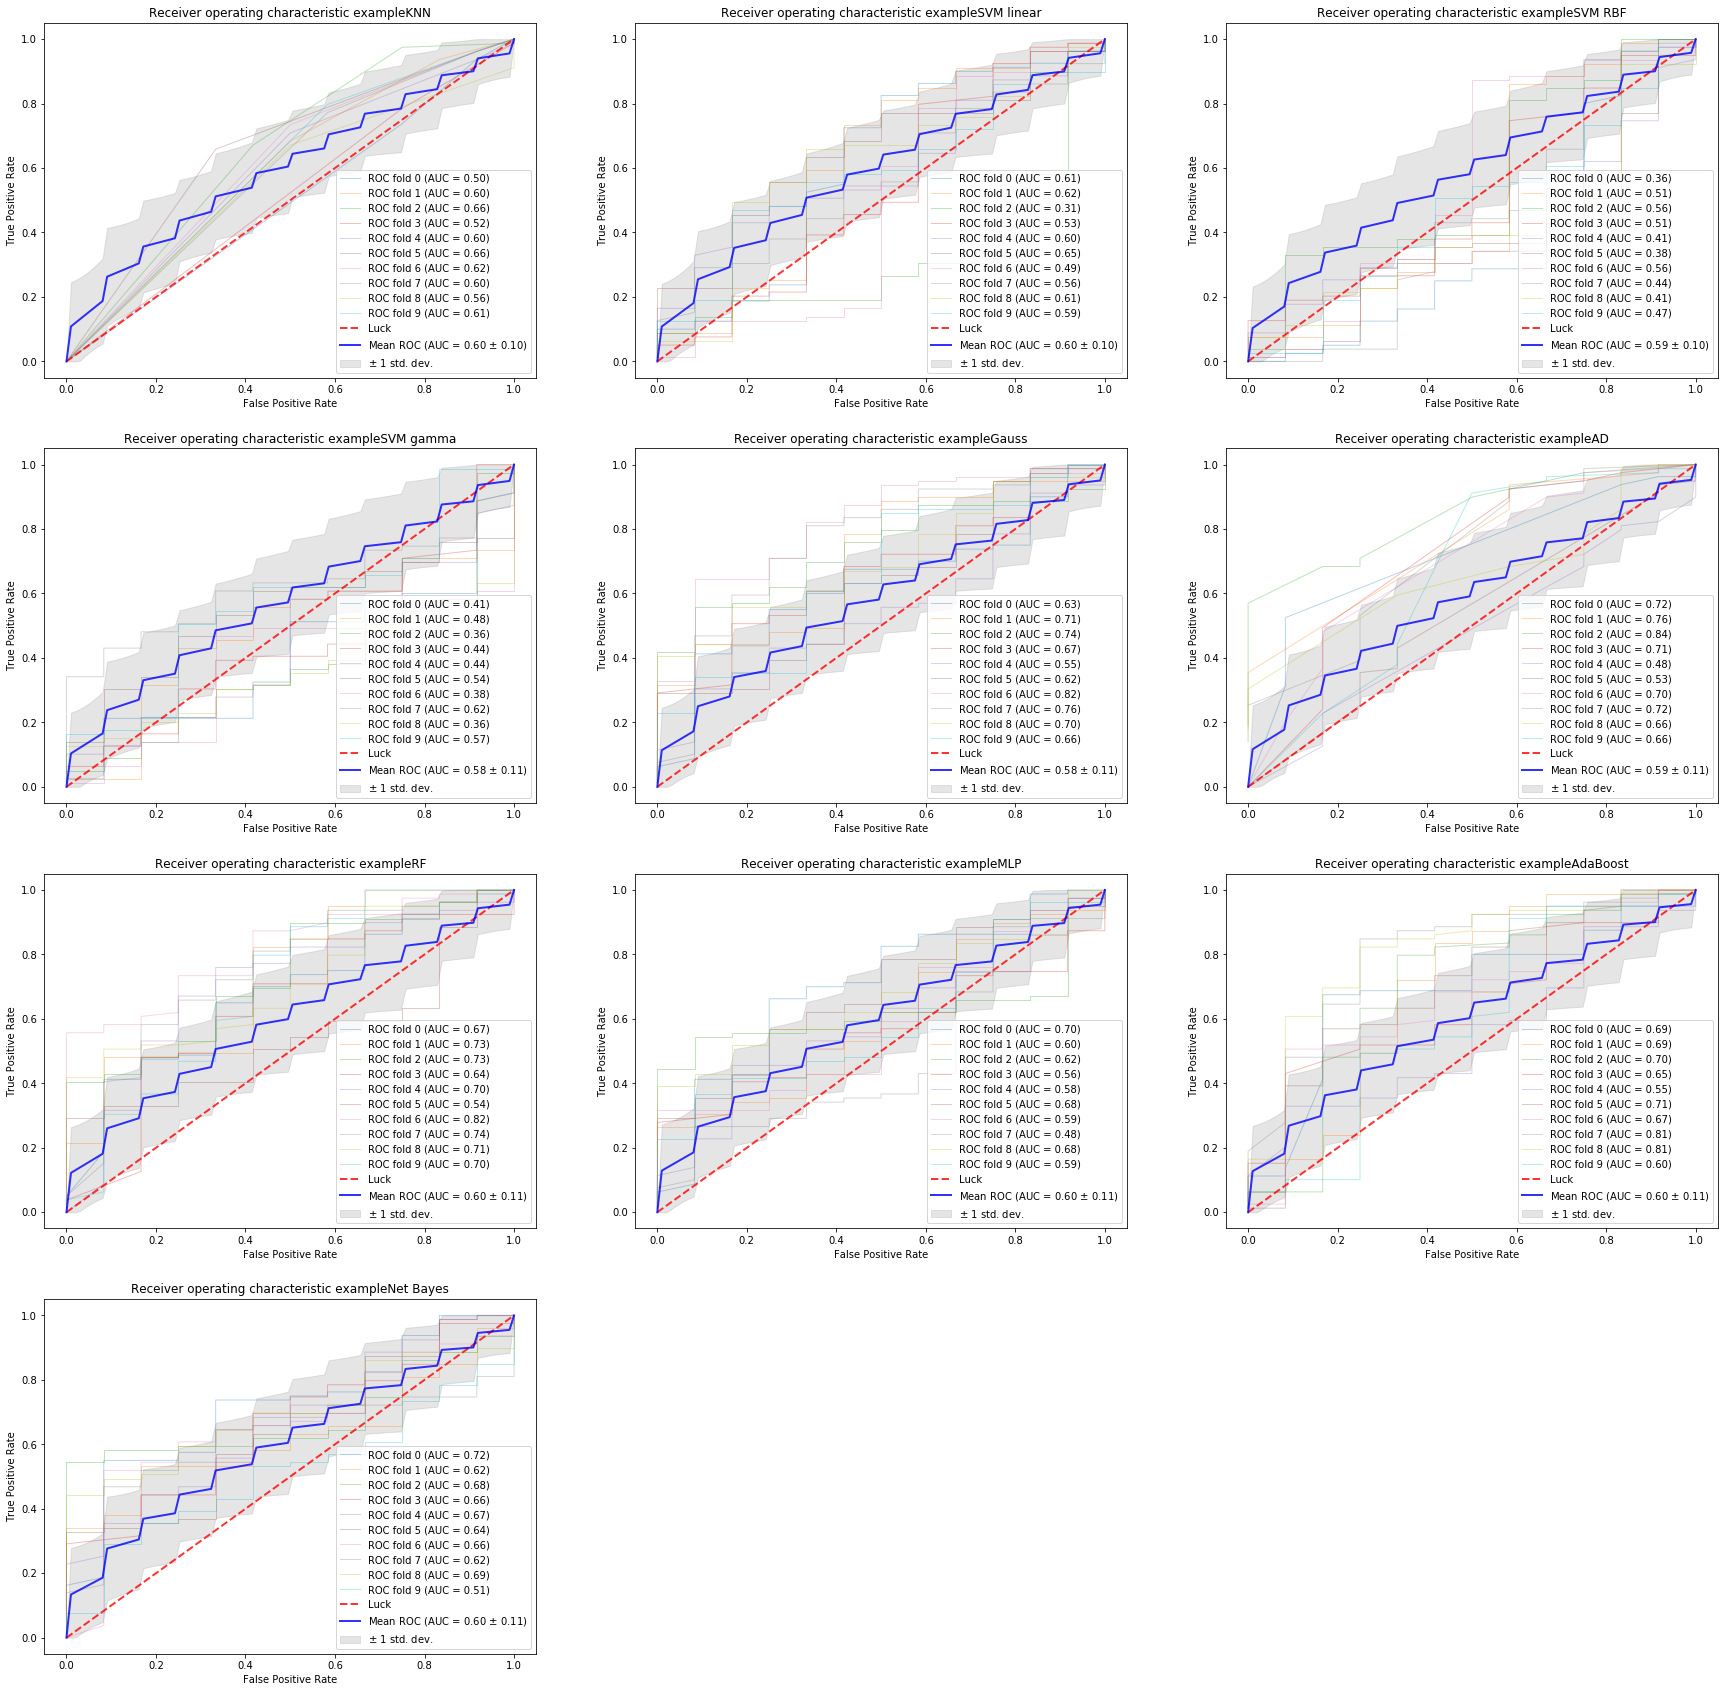

In [17]:
fig = plt.figure(figsize=(30,30))
i = 1
row = 4
col = 3
for c,clf in zip(cls,classifiers):
    a = fig.add_subplot(row, col, i)
    imgshow = roc(cv, X, y, mean_fpr_dall, aucs_dall,tprs_dall,clf,c)
    i+=1
fig.savefig("all_AllData_classifiers.png")

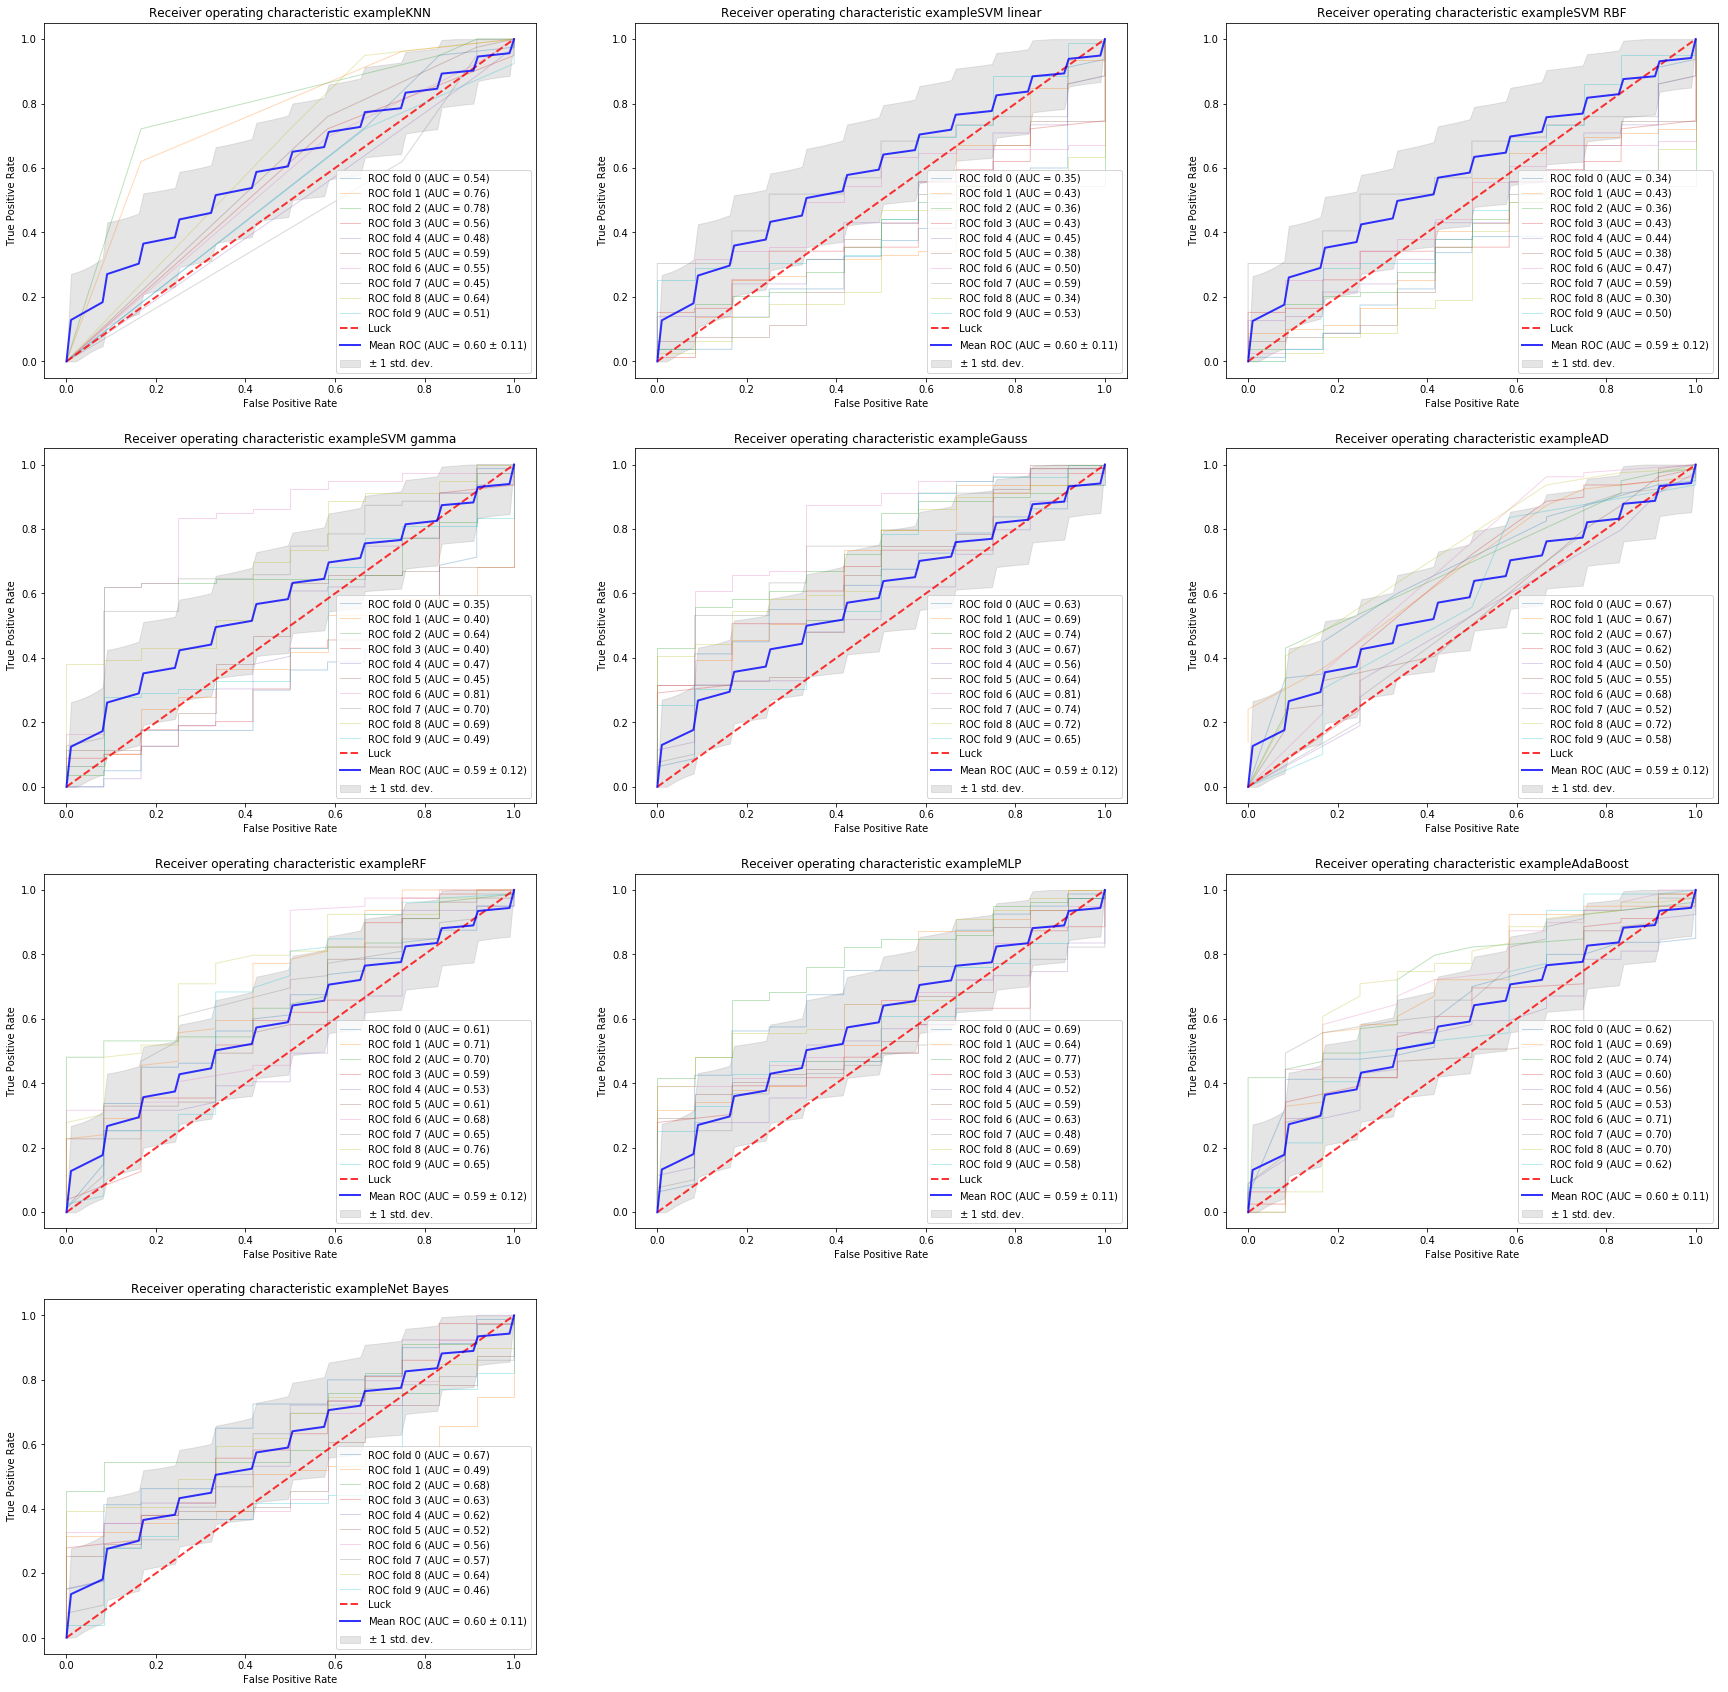

In [18]:
fig = plt.figure(figsize=(30,30))
i = 1
row = 4
col = 3
for c,clf in zip(cls,classifiers):
    a = fig.add_subplot(row, col, i)
    imgshow = roc(cv, pd.DataFrame(X_svm), y_svm, mean_fpr_dall, aucs_dall,tprs_dall,clf,c)
    i+=1
fig.savefig("all_AllData_svm_classifiers.png")

## Trying to remove correlated genes

In [19]:
n_data = X.iloc[:,X_new.get_support()]
trap_ndata = n_data.T
corr_data = trap_ndata.corr(method='spearman')
threshold = 0.50
col_corr = set() # Set of all the names of deleted columns
for i in range(len(corr_data.columns)):
    for j in range(i):
        if corr_data.iloc[i, j] >= threshold:
            colname = corr_data.columns[i] # getting the name of column
            col_corr.add(colname)
            if colname in trap_ndata.columns:
                del trap_ndata[colname] # deleting the column from the dataset


In [20]:
x1_data = trap_ndata.T
y1_data = y.iloc[list(trap_ndata)]
print(x1_data.shape)

(227, 5)


In [21]:
random_state = np.random.RandomState(0) 
cv = StratifiedKFold(n_splits=2)
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:432: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:434: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:434: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:434: RuntimeWarning:

invalid value encountered in subtract



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

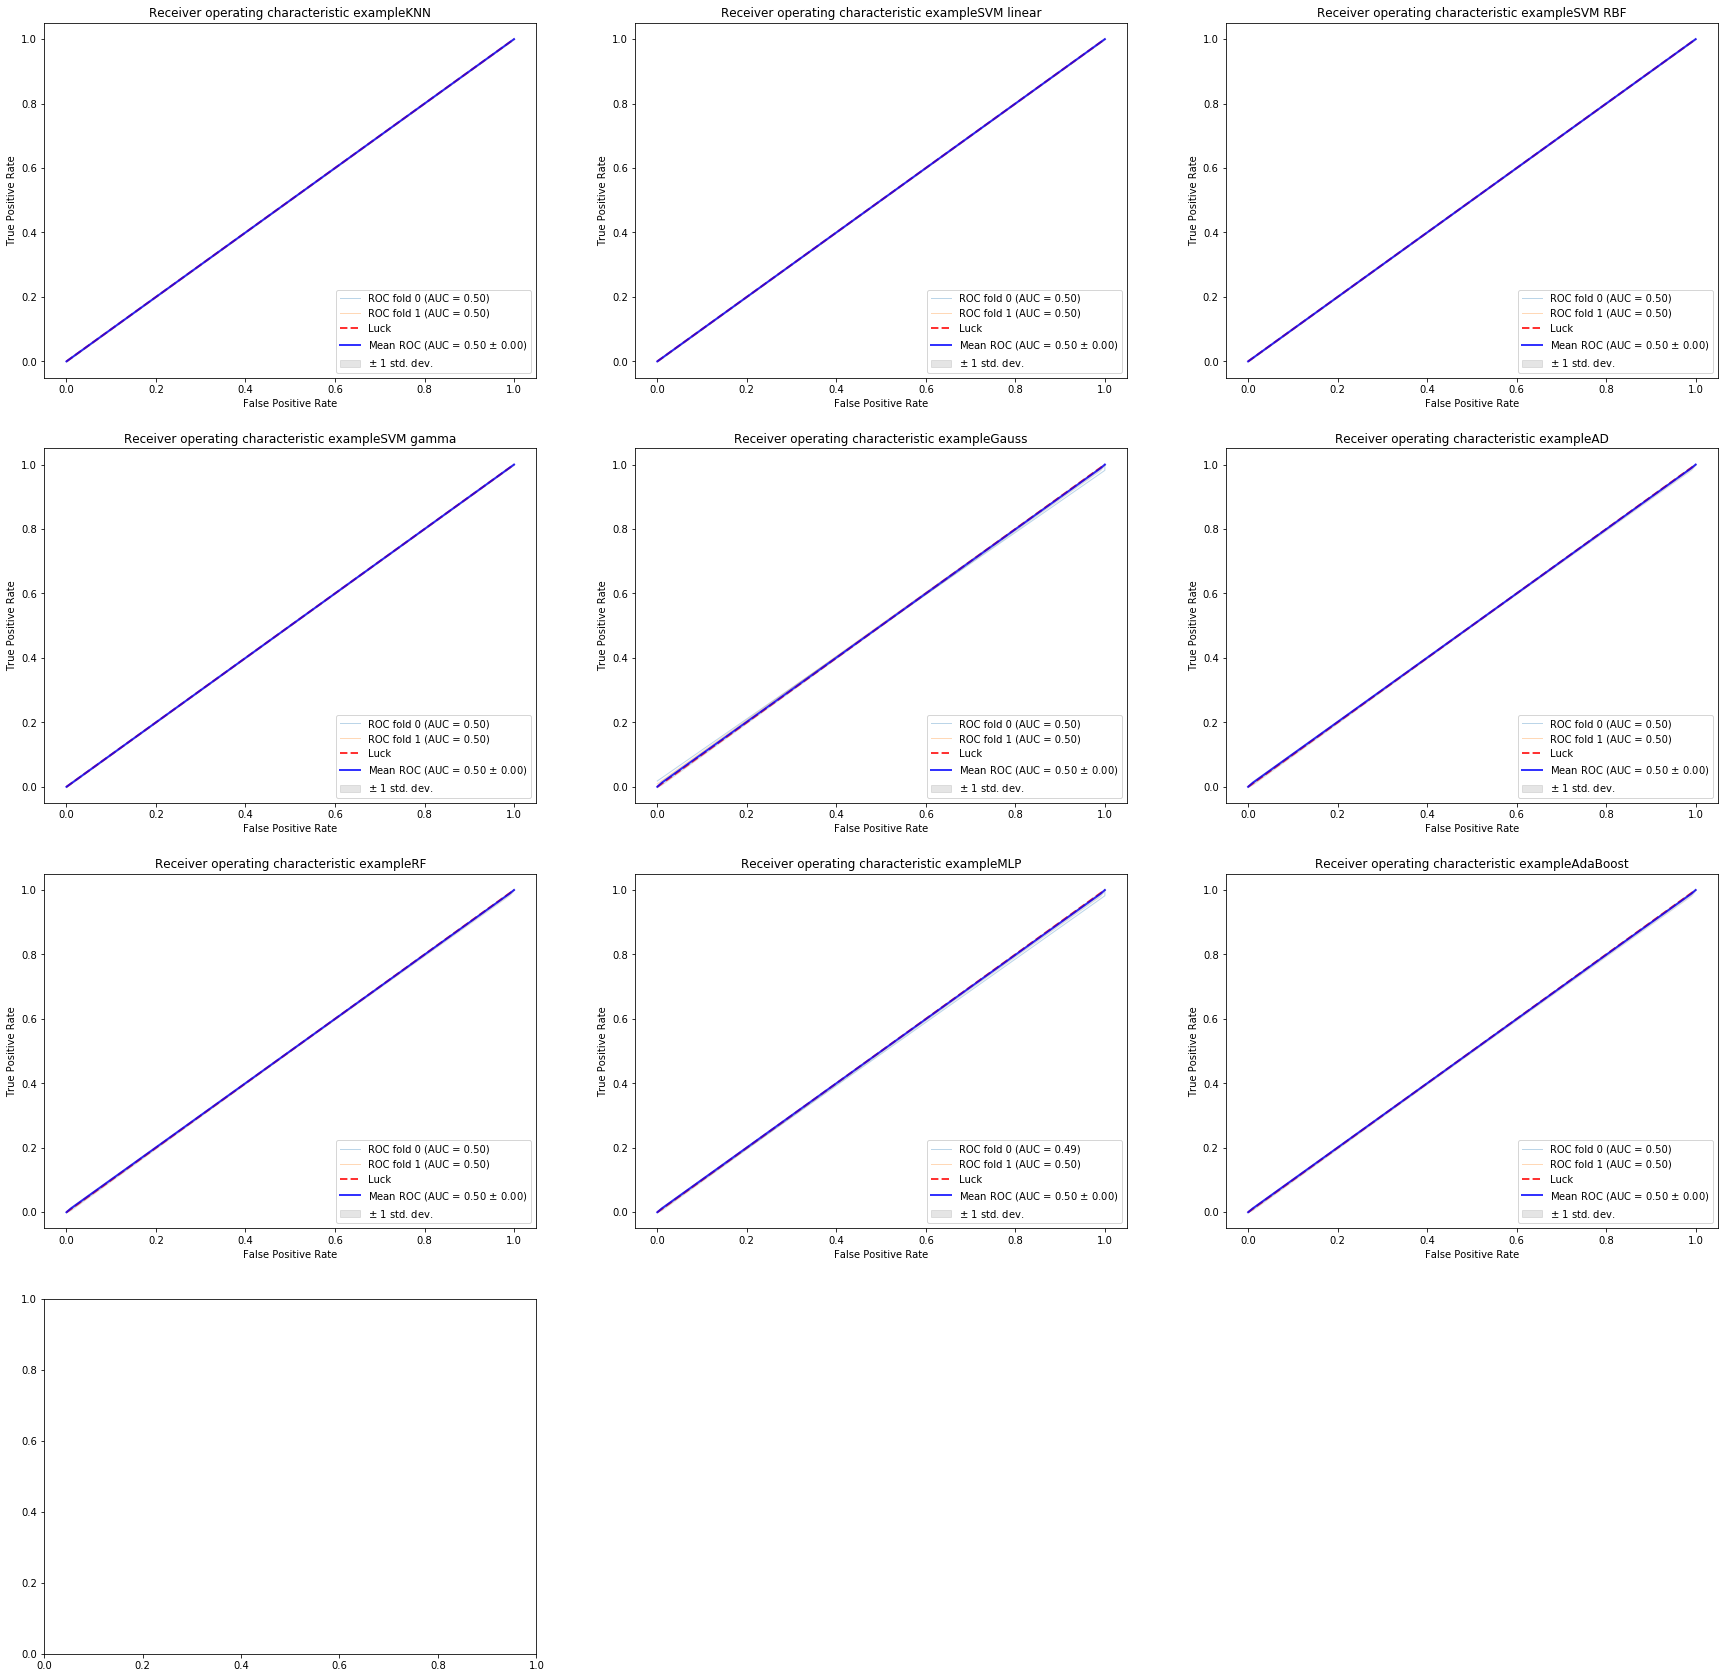

In [22]:
fig = plt.figure(figsize=(30,30))
i = 1
row = 4
col = 3
for c,clf in zip(cls,classifiers):
    a = fig.add_subplot(row, col, i)
    imgshow = roc(cv, x1_data, y1_data, mean_fpr_dall, aucs_dall,tprs_dall,clf,c)
    i+=1
fig.savefig("all_classifiers_genes_sel.png")